In [1]:
from deep_traffic_generation.tcvae import TCVAE
from deep_traffic_generation.VAE_Generation import SingleStageVAE
from traffic.algorithms.generation import Generation
from deep_traffic_generation.core.datasets import TrafficDataset, TrafficDatasetPairs
from traffic.core import Traffic

from sklearn.preprocessing import MinMaxScaler
import torch
import numpy as np
from os import walk

In [2]:
traffic1 = Traffic.from_file("../deep_traffic_generation/data/training_datasets/landings_south_LFPO_06.pkl")
traffic2 = Traffic.from_file("../deep_traffic_generation/data/training_datasets/takeoffs_south_LFPO_07.pkl")

In [3]:
##Attention, peut-être il va falloir appliquer le scaler de manière plus intelligente

test = TrafficDatasetPairs.from_file(
    ("../deep_traffic_generation/data/training_datasets/landings_south_LFPO_06.pkl", "../deep_traffic_generation/data/training_datasets/takeoffs_south_LFPO_07.pkl"),
    features=["track", "groundspeed", "altitude", "timedelta"],
    scaler=MinMaxScaler(feature_range=(-1,1)),
    # scaler=None,
    shape="image",
    info_params={"features": ["latitude", "longitude"], "index": -1},
)

In [3]:
from argparse import Namespace
from pathlib import PosixPath

config = Namespace(train_ratio=0.8, val_ratio=0.2, batch_size=500, test_batch_size=None, early_stop=None, data_path=[PosixPath('data/training_datasets/landings_LFPO_06.pkl'), PosixPath('data/training_datasets/takeoffs_LFPO_07.pkl')], features=['track', 'groundspeed', 'altitude', 'timedelta'], info_features=[], info_index=None, logger=True, enable_checkpointing=True, default_root_dir=None, gradient_clip_val=0.5, gradient_clip_algorithm=None, num_nodes=1, num_processes=None, devices=None, gpus=None, auto_select_gpus=False, tpu_cores=None, ipus=None, enable_progress_bar=True, overfit_batches=0.0, track_grad_norm=-1, check_val_every_n_epoch=1, fast_dev_run=False, accumulate_grad_batches=None, max_epochs=None, min_epochs=None, max_steps=-1, min_steps=None, max_time=None, limit_train_batches=None, limit_val_batches=None, limit_test_batches=None, limit_predict_batches=None, val_check_interval=None, log_every_n_steps=50, accelerator=None, strategy=None, sync_batchnorm=False, precision=32, enable_model_summary=True, weights_save_path=None, num_sanity_val_steps=2, resume_from_checkpoint=None, profiler=None, benchmark=None, deterministic=None, reload_dataloaders_every_n_epochs=0, auto_lr_find=False, replace_sampler_ddp=True, detect_anomaly=False, auto_scale_batch_size=False, plugins=None, amp_backend='native', amp_level=None, move_metrics_to_cpu=False, multiple_trainloader_mode='max_size_cycle', network_name='tcvae_pairs', lr=0.001, lr_step_size=200, lr_gamma=0.5, dropout=0.0, encoding_dim=128, h_dims=[128, 128, 128], llv_coef=1.0, llv_coef_delta_t=800.0, kld_coef=1.0, reg_pseudo=False, scale=1.0, sampling_factor=10, kernel_size=16, dilation_base=2, n_components=800, prior='vampprior', exemplar_path=None)

In [4]:
from deep_traffic_generation.tcvae_pairs import TCVAE_Pairs
from deep_traffic_generation.core.utils import get_dataloaders

train_loader, val_loader, test_loader = get_dataloaders(
    test,
    0.8,
    0.2,
    1000,
    100,
)

model = TCVAE_Pairs(test.parameters, config = config)


In [5]:
output = model(*model.example_input_array)

In [13]:
model.gaussian_likelihood(model.example_input_array[0], output[2], torch.Tensor([1]))

tensor([-1756.2554], grad_fn=<SumBackward1>)

In [4]:
dataset1 = TrafficDataset.from_file(
    "../deep_traffic_generation/data/training_datasets/landings_LFPO_06.pkl",
    features=["track", "groundspeed", "altitude", "timedelta"],
    scaler=MinMaxScaler(feature_range=(-1,1)),
    shape="image",
    info_params={"features": ["latitude", "longitude"], "index": -1},
)

dataset2 = TrafficDataset.from_file(
    "../deep_traffic_generation/data/training_datasets/takeoffs_LFPO_07.pkl",
    features=["track", "groundspeed", "altitude", "timedelta"],
    scaler=MinMaxScaler(feature_range=(-1,1)),
    shape="image",
    info_params={"features": ["latitude", "longitude"], "index": -1},
)

In [4]:
#Code pour 1 seul traffic en entrée

path = "../deep_traffic_generation/lightning_logs/tcvae/version_1/"

t = SingleStageVAE(X = dataset1, sim_type = "generation")
t.load(path, dataset1.parameters)
g = Generation(generation=t, features = t.VAE.hparams.features, scaler=dataset1.scaler) 

In [52]:
# times1 = traffic1.summary(["flight_id", "start", "stop"])
# times2 = traffic2.summary(["flight_id", "start", "stop"])

data1 = np.stack(list(np.append([f.flight_id, f.start, f.stop], f.data[["track", "groundspeed", "altitude", "timedelta"]].values.ravel()) for f in traffic1))
data2 = np.stack(list(np.append([f.flight_id, f.start, f.stop], f.data[["track", "groundspeed", "altitude", "timedelta"]].values.ravel()) for f in traffic2))

# Sort according to start
data1 = data1[np.argsort(data1[:,1])]
data2 = data2[np.argsort(data2[:,1])]

In [40]:
# Takes 12 min
from tqdm.autonotebook import tqdm 
import itertools
import pandas as pd

pairs = []

for x,y in tqdm(itertools.product(data1,data2)): 

    delta_t = y[1] - x[1]

    if delta_t < pd.Timedelta(0):
        pass

    #make sure that delta_t is smaller than the total duration of the reference (the takeoff)
    elif (delta_t < x[2] - x[1]): 
        pairs.append(np.concatenate(([x[0], y[0], delta_t], x[3:], y[3:])))

    # Next flights only begin after i have finished : only works if sorted 
    elif delta_t > x[2] - x[1]:
        pass


0it [00:00, ?it/s]

In [42]:
test = np.stack(pairs)
(test[:,2]< pd.Timedelta(0)).sum()

In [44]:
(test[:,2]< pd.Timedelta(0)).sum()

0

In [29]:
# 2min

from multiprocessing import Pool
import itertools
import os
import pandas as pd

# Always the first dataset in argument as reference

#Try with multi-processing

# iter is a line of the reference array data 1
def calculate_pairs(iter):
    x, y = iter
    delta_t = y[1] - x[1]
    len_x = x[2] - x[1]
    len_y = y[2] - y[1]

    #modified according to sandobox_tcas
    if delta_t < -len_y or (delta_t > len_x):
        return
    
    #make sure that delta_t is smaller than the total duration of the reference (the takeoff)
    elif (delta_t < len_x): 
        return np.concatenate(([x[0], y[0], delta_t.total_seconds()], x[3:], y[3:]))


with Pool(processes=os.cpu_count()) as p: 
        pairs = p.map(calculate_pairs, itertools.product(data1,data2))
        p.close()
        p.join()    

In [39]:
test.pairs_id

array([['17LQ_000', 'RAM781S_3669'],
       ['A7MBK_001', 'AFR644_832'],
       ['A7MBK_001', 'EJU92KQ_2735'],
       ...,
       ['XK754B_7752', 'TVF48DW_5256'],
       ['XK754B_7752', 'TVF7016_5621'],
       ['XK754B_7752', 'TVF8074_6114']], dtype=object)

In [30]:
pairs = np.stack([x for x in pairs if x is not None])
len(pairs)

17897

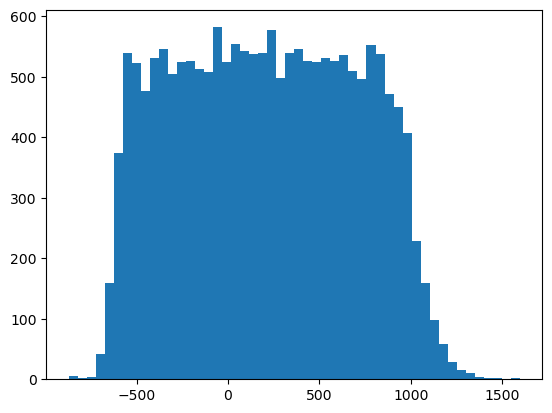

In [25]:
# To calculate delta_t, we take each landing and look at aircrafts that take-off AFTER the landing entered the bubble
#That's why every delta_t is positive (unlike sandbox_t_cas_generation)

import matplotlib.pyplot as plt
times = [x[2].total_seconds() for x in pairs]

plt.hist(times, bins = 50)
plt.show()

# Problem 

In the classical TCVAE, we have as input a dataset (N, 4, 200) (form of an image). Here, we would like something like (N, 8, 200) + (N, 1) (2 images stacked + one scalar). 
Methods : 
- Put the datasets of pairs (N, 8, 200) in the TCVAE, flatten the output, concatenate the scalar and put it in a dense layer. https://stats.stackexchange.com/questions/299322/combining-image-and-scalar-inputs-into-a-neural-network
- Other : Learning Hand-Eye Coordination for Robotic Grasping with Deep Learning and Large-Scale Data Collection. It uses the scalar as a bias term, with matching dimensions  

For that we have to :
- Create a new class in dataset called TrafficDatasetPairs
- Create a new tcvae_pairs.py. Pretty much identical that tcvae.py but returns 2 trajectories concatenated + one scalar
- Modify TCVAE there to take into account the delta_t after the TCN encoder (we concatenate it within before the final dense layers), and in the decoder the delta_t is outputted right before entering the TCN. 
- Add a term for the reconstruction of the scalar to the loss (+ scaling it compared to other terms with a reg lambda)

Modifications : 
- The addition of the new neural nets is done in the tcvae_pairs.py file. 
- We have to find the forward step of the model to split the input (delta_t + trajectories) and to feed it to the right neural networks. That's in the abstract.py file (create a new class as well). In the training step of the class in abstract, batch[0] is the pair of trajecotry, and batch[1] the delta_t. We have to modify also the encoder architecture in tcvae.py.
- The addition of the term in the loss is done in the abstract.py file. (We will create a new class)


In [5]:
from deep_traffic_generation.core.utils import get_dataloaders

train_loader, val_loader, test_loader = get_dataloaders(
    test,
    0.8,
    0.2,
    100,
    100,
)

In [6]:
for x in train_loader:
    print(x)
    break

[tensor([[[3.0379e+02, 3.0389e+02, 3.0389e+02,  ..., 6.1902e+01,
          6.1902e+01, 6.2281e+01],
         [3.1600e+02, 3.1600e+02, 3.1600e+02,  ..., 1.3400e+02,
          1.3400e+02, 1.3300e+02],
         [1.2700e+04, 1.2700e+04, 1.2700e+04,  ..., 1.0000e+03,
          9.2500e+02, 8.5000e+02],
         ...,
         [1.5300e+02, 1.5300e+02, 1.5500e+02,  ..., 4.2200e+02,
          4.2200e+02, 4.2200e+02],
         [3.0500e+03, 3.1250e+03, 3.2500e+03,  ..., 2.3275e+04,
          2.3400e+04, 2.3425e+04],
         [0.0000e+00, 2.0000e+00, 6.0000e+00,  ..., 5.7000e+02,
          5.7400e+02, 5.7600e+02]],

        [[3.0866e+02, 3.0876e+02, 3.0876e+02,  ..., 6.1952e+01,
          6.1952e+01, 6.1783e+01],
         [3.7100e+02, 3.7100e+02, 3.7100e+02,  ..., 1.3800e+02,
          1.3800e+02, 1.4000e+02],
         [1.2075e+04, 1.2075e+04, 1.2075e+04,  ..., 8.5000e+02,
          8.2500e+02, 7.5000e+02],
         ...,
         [1.5700e+02, 1.5800e+02, 1.5900e+02,  ..., 4.3400e+02,
          4.32

In [12]:
x[1]

tensor([-302.,  968., -358.,  760.,  948.,  438., 1014.,  116., -256.,  700.,
         -48.,  384., -128.,  650.,  862.,  162.,   60.,  176.,  558., -286.,
        -590., -124., -460.,  644.,   76.,  668.,  614.,   -8., -312.,  270.,
         804.,  554.,  188.,  302.,   76., -114.,  562., -114.,  786.,  326.,
        -542.,  472.,  292., -548., -112.,  132., -464.,  310., -414., -654.,
         752.,  452.,  304., -372.,  428., -360.,  964.,  616.,  870., -330.,
         146.,   82.,  -28., -538.,  862., -144., -528.,  164.,  760.,  308.,
        -356.,  402.,  274.,  680., -258., -402.,  224.,  590.,  544.,  938.,
          78.,  928.,  200.,  180.,   92., -150., -148., -142.,  640.,  196.,
        -462.,  374.,  970.,  822.,  556., -464.,  866.,  718.,  172.,  602.])